<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/olgap%2Fmachine_learning_0.06/linear_regression_average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [2,099 kB]
Get:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main amd64 Packages [1,076 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,540 kB]
Ign:13 https://developer.download.nvidia.

In [3]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://uaresources.s3.us-west-1.amazonaws.com/sentiment_joined_events_twitter_post_ml.csv"

spark.sparkContext.addFile(url)
text_df = spark.read.csv(SparkFiles.get("sentiment_joined_events_twitter_post_ml.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
text_df.show()

+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|_c0|       username|following|followers|totaltweets|usercreatedts|tweetcreatedts|retweetcount|            hashtags|language|favorite_count|is_retweet|is_quote_status|extractedts|weekofyear|date_published|search_result| weight|        cleaned_text|            negative|             neutral|            positive|
+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|  0|      WashTimes|   1893.0| 417389.0|   335685.0|   2008-05-

In [15]:
# convert spark dataframe to pandas
joined_data_df = text_df.toPandas()
joined_data_df.head(5)




,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,cleaned_text,negative,neutral,positive
0,0,WashTimes,1893.0,417389.0,335685.0,2008-05-05,2022-02-26,0.0,"[{'text': 'UkraineCrisis', 'indices': [102, 11...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,democrats urge biden to counter pain at pump w...,0.222473,0.747085,0.030443
1,1,jacarroll,64.0,254.0,110.0,2008-01-07,2022-02-26,0.0,"[{'text': 'StandWithUkriane', 'indices': [58, ...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,now is the time to annex cuba just sayin,0.078324,0.799905,0.121771
2,2,axelk,5766.0,5329.0,119448.0,2007-06-14,2022-02-26,4.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,just grasping at straws here but does anyone h...,0.147500,0.824443,0.028057
3,3,ds2719,294.0,172.0,15270.0,2007-07-21,2022-02-26,894.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,this is huge russia will be expelled from the ...,0.883955,0.109929,0.006116
4,4,scholar_at_arms,975.0,75.0,1988.0,2008-09-26,2022-02-26,0.0,"[{'text': 'KyivDefiant', 'indices': [18, 30]},...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,please take care,0.063437,0.643451,0.293113


# Explore the data if nothing lost

In [16]:
# Converting 'tweetcreatedts' to dtype datetime
joined_data_df['tweetcreatedts']=pd.to_datetime(joined_data_df['tweetcreatedts'])

In [17]:
earliest_tweet = joined_data_df["tweetcreatedts"].min()
latest_tweet = joined_data_df["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2022-02-24 00:00:00, and the latest was at 2022-08-18 00:00:00


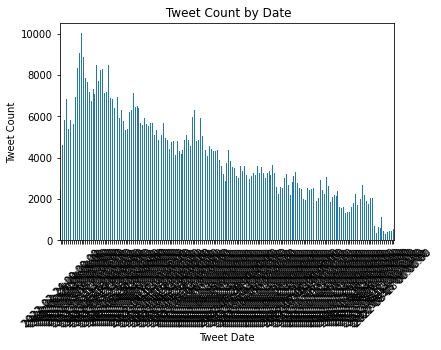

In [18]:
from pandas.core.arrays.datetimelike import DatetimeLikeScalar
from numpy.core.multiarray import datetime_as_string
#Get the plot of tweet count by date 
dates = joined_data_df["tweetcreatedts"]

# group tweet timestamps by date and get tweet count for each date
tweetcount_by_date = joined_data_df["tweetcreatedts"].groupby(dates).size()

# plot bar graph of tweet count by date
tweetcount_by_date.plot.bar();

plt.title(" Tweet Count by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.show()

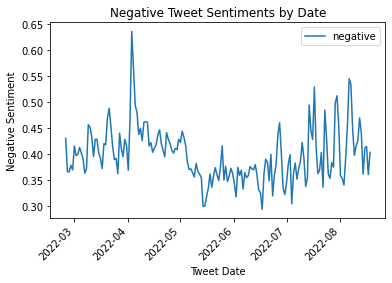

In [19]:
#Get the plot of negative score by date of tweet
negative_df = joined_data_df[['tweetcreatedts', 'negative']]

negative_by_date = negative_df.groupby([negative_df['tweetcreatedts']]).mean()

# plot bar graph of tweet count by date
negative_by_date.plot.line();

plt.title("Negative Tweet Sentiments by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()


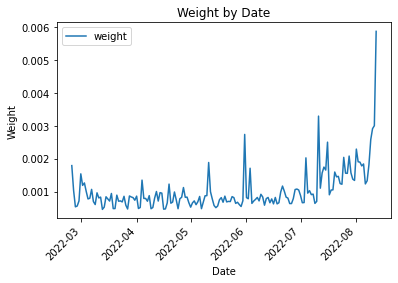

In [20]:
#Get the plot of day weight by date
joined_data_df.plot.line(x='tweetcreatedts', y='weight');

plt.title("Weight by Date")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Cleaning and converting the data

In [21]:
# Drop the not needed column
joined_data_df.drop("username", axis=1, inplace=True)
joined_data_df.drop("usercreatedts", axis=1, inplace=True)
joined_data_df.drop("language", axis=1, inplace=True)
joined_data_df.drop("favorite_count", axis=1, inplace=True)
joined_data_df.drop("extractedts", axis=1, inplace=True)
joined_data_df.drop("weekofyear", axis=1, inplace=True)
joined_data_df.drop("neutral", axis=1, inplace=True)
joined_data_df.drop("positive", axis=1, inplace=True)
joined_data_df.drop("search_result", axis=1, inplace=True)
joined_data_df.drop("retweetcount", axis=1, inplace=True)
joined_data_df.drop("hashtags", axis=1, inplace=True)
joined_data_df.drop("date_published", axis=1, inplace=True)

In [22]:
# convert text to text lenght and drop the text
joined_data_df['text_length']  = joined_data_df['cleaned_text'].str.len()
joined_data_df.drop("cleaned_text", axis=1, inplace=True)

In [23]:
# Change object type to boolean for columns 'is_retweet' and 'is_quote_status'
joined_data_df["is_retweet"] = joined_data_df['is_retweet'].astype(bool)
joined_data_df["is_quote_status"] = joined_data_df['is_quote_status'].astype(bool)

# Get the average score of negative sentiment by date

In [24]:
#Ensure that 'tweetcreatedts' is of dtype datetime
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713009 entries, 0 to 713008
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   _c0              713009 non-null  int32         
 1   following        713008 non-null  float64       
 2   followers        713008 non-null  float64       
 3   totaltweets      713008 non-null  float64       
 4   tweetcreatedts   713008 non-null  datetime64[ns]
 5   is_retweet       713009 non-null  bool          
 6   is_quote_status  713009 non-null  bool          
 7   weight           710367 non-null  float64       
 8   negative         713009 non-null  float64       
 9   text_length      712998 non-null  float64       
dtypes: bool(2), datetime64[ns](1), float64(6), int32(1)
memory usage: 42.2 MB


In [25]:
# Create a new dataframe with average score
average_score_df = joined_data_df.groupby(joined_data_df['tweetcreatedts'].dt.date)['negative'].mean().reset_index()
average_score_df.head(5)

,tweetcreatedts,negative
0,2022-02-24,0.430596
1,2022-02-25,0.366838
2,2022-02-26,0.366291
3,2022-02-27,0.378774
4,2022-02-28,0.370100


In [26]:
# Create a new dataframe with average weight
average_weight_df = joined_data_df.groupby(joined_data_df['tweetcreatedts'].dt.date)['weight'].mean().reset_index()
average_weight_df.head(5)

,tweetcreatedts,weight
0,2022-02-24,0.001789
1,2022-02-25,0.001035
2,2022-02-26,0.000533
3,2022-02-27,0.000558
4,2022-02-28,0.000714


In [27]:
average_df = pd.merge(average_score_df, average_weight_df, on='tweetcreatedts')
print(average_df)


    tweetcreatedts  negative    weight
0       2022-02-24  0.430596  0.001789
1       2022-02-25  0.366838  0.001035
2       2022-02-26  0.366291  0.000533
3       2022-02-27  0.378774  0.000558
4       2022-02-28  0.370100  0.000714
..             ...       ...       ...
170     2022-08-14  0.361859       NaN
171     2022-08-15  0.411738       NaN
172     2022-08-16  0.415048       NaN
173     2022-08-17  0.361068       NaN
174     2022-08-18  0.403706       NaN

[175 rows x 3 columns]


In [28]:
average_df = average_df.dropna()
print(average_df)

    tweetcreatedts  negative    weight
0       2022-02-24  0.430596  0.001789
1       2022-02-25  0.366838  0.001035
2       2022-02-26  0.366291  0.000533
3       2022-02-27  0.378774  0.000558
4       2022-02-28  0.370100  0.000714
..             ...       ...       ...
164     2022-08-08  0.448524  0.001819
165     2022-08-09  0.397943  0.002583
166     2022-08-10  0.416446  0.002915
167     2022-08-11  0.425691  0.003005
168     2022-08-12  0.469609  0.005879

[169 rows x 3 columns]


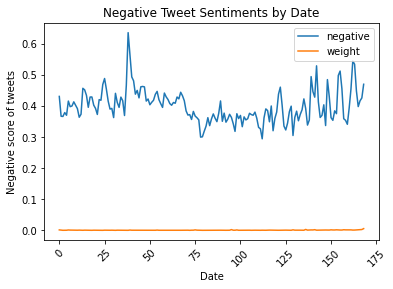

In [30]:
# Get the plot of negative score and weight by timeline

average_df.plot.line();

plt.title("Negative Tweet Sentiments by Date")
plt.xlabel("Date")
plt.ylabel("Negative score of tweets")
plt.xticks(rotation=45)
plt.show()

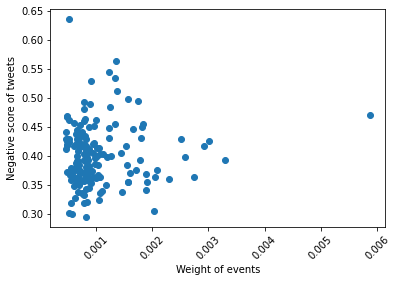

In [31]:
# Get the plot by weight of event
plt.scatter(average_df.weight, average_df.negative)
plt.xlabel('Weight of events')
plt.ylabel('Negative score of tweets')
plt.xticks(rotation=45)
plt.show()

# Linear regression


We assume that we can predict emotional importance of the events of war by the sentiment analysis of tweets. For first segment we use for that simple linear regression, but at the next segment we could try to make clasterisation for Twitter users for more accurate trend prediction.

Our mockup dataset has data for two days only from 180 days of war yet. This is due to the duration of the calculation of sentiment analysis data: even for that two days it took 6 hours to get the result due to size of twitter data.

In [32]:
# Format the data to meet the requirements of the Scikit-learn library
# Examine the first five entries in X
X = average_df.negative.values.reshape(-1, 1)
X[:5]

array([[0.4305959 ],
       [0.36683777],
       [0.36629098],
       [0.37877387],
       [0.3700999 ]])

In [33]:
# What is the shape of X - rows and columns
X.shape

(169, 1)

In [34]:
# Assign the target variable, or the Weight column, to y. 
# It's possible to reshape this column, as we did with X, it's not required in this instance
y = average_df.weight
y[:5]

0    0.001789
1    0.001035
2    0.000533
3    0.000558
4    0.000714
Name: weight, dtype: float64

In [35]:
# What is the shape of y - rows and columns
y.shape

(169,)

In [36]:
# Create an instance of the linear regression model
# That will analyze the data and store information specific to this dataset
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [37]:
# Generate predictions
y_pred = model.predict(X)
print(y_pred.shape)

(169,)


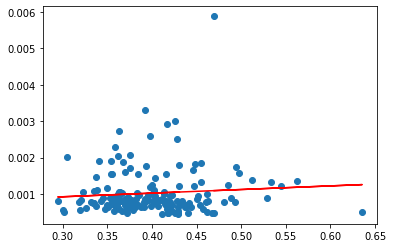

In [38]:
# Plot the predictions as a red line against the data points
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

In [39]:
# Examine the specific parameters of our model: the slope and the y-intercept
print(model.coef_)
print(model.intercept_)

[0.00099367]
0.0006276569458025251


Looks like despite our idea that average negative sentiment of the day corresponding somehow with the weight of the day (the ratio of the number of articles about relevant news that are written on a given day to the number for all days), it is not, and we were wrong. Let's check this with the Probability Density Function.

# Probability Density Function

PDF is used to specify the probability of the random variable falling within a particular range of values, as opposed to taking on any one value. 

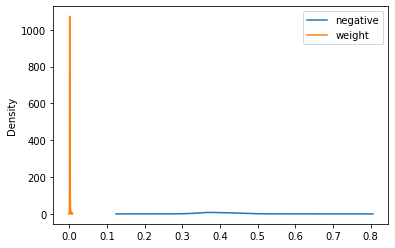

In [40]:
# Generate Kernel Density Estimate plot using Gaussian kernels, using the Density method to fing out

ax = average_df.plot.kde()

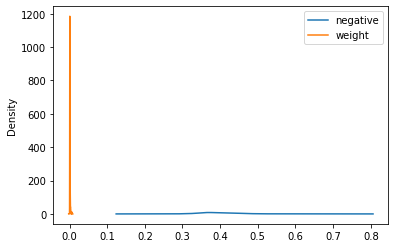

In [41]:
# Using a small bandwidth value 
ax = average_df.plot.kde(bw_method=0.3)

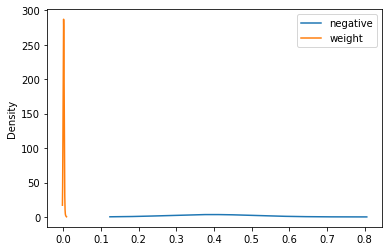

In [42]:
# Using a large bandwidt value
ax = average_df.plot.kde(bw_method=2)

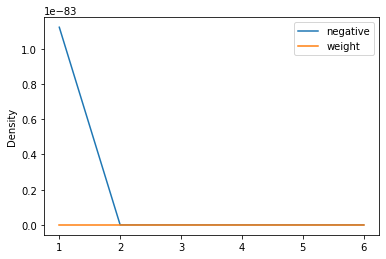

In [43]:
# Determine the evaluation points for the plot of the estimated PDF
ax = average_df.plot.kde(ind=[1, 2, 3, 4, 5, 6])